### 1. 資料前處理

 a. 取出10.11.12月資料

 b. 缺失值以及無效值以前後一小時平均值取代 (如果前一小時仍有空值，再取更前一小時)

 c. NR表示無降雨，以0取代

 d. 將資料切割成訓練集(10.11月)以及測試集(12月)

 e. 製作時序資料: 將資料形式轉換為行(row)代表18種屬性，欄(column)代表逐時數據資料

     **hint: 將訓練集每18行合併，轉換成維度為(18,61*24)的DataFrame(每個屬性都有61天*24小時共1464筆資料)
     ** # 表示儀器檢核為無效值，* 表示程式檢核為無效值，x 表示人工檢核為無效值，A 係指因儀器疑似故障警報所產生的無效值，空白 表示缺值。



In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('新竹_2021.csv')
data.columns = ['A', 'date', 'attributes', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
data.drop(columns = ['A'],inplace = True) #we don't need "新竹"as our data
data.drop(columns = ['date'],inplace = True)#remove date column,useless(prediciton is hour based)
data.drop(index = [0],inplace = True) #index 0 ->'------------' removed
#print(data)
#we should replace error messages
#replace_ = ['#','*','x','A','NA'] #NA -> 空白
#there's a long space after these text...
replace_ = ['#                              ', 'x                              ', '*                              '
                 , 'A                              ', 'NA                             ']
data = data.apply(lambda x:x.replace(replace_,np.nan))
#fetch the training(10~11),testing data
#10-11:4914-6012
#12:6012-
#print(data.iloc[:,1:])
train_d = data.iloc[4914:6012,:]
test_d = data.iloc[6012:,:]
print(test_d)

                attributes     0     1     2     3     4     5     6     7  \
6013  AMB_TEMP              17.8  17.2  16.7  16.3  15.9  15.5  15.4  15.6   
6014  CH4                   2.04  2.04  2.04  2.04  2.03  2.03  2.04  2.05   
6015  CO                     0.3  0.29  0.28  0.27  0.26  0.27   0.3  0.37   
6016  NMHC                  0.05  0.06  0.04  0.03  0.05  0.05  0.06  0.08   
6017  NO                     0.8   0.4   0.4   0.3   0.3   0.3   0.6   1.8   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
6566  THC                   2.24  2.22  2.19  2.17  2.15   2.1   2.1  2.11   
6567  WD_HR                   38    51    50    47    53    53    46    49   
6568  WIND_DIREC              37    59    37    50    62    42    41    59   
6569  WIND_SPEED             2.6   2.6   2.3   2.4   3.4   3.2   3.1     3   
6570  WS_HR                  2.5     2     2     2   2.5   2.6   2.6   2.5   

         8  ...    14    15    16    17    18    19    20    21

In [2]:
#print(train_d)

In [3]:
print(len(train_d))

1098


In [4]:
#process the data of train & test respectively
def process(data):
    final = []
    for i in range(18): #traverse the 18 attributes of one day
        j = i
        alld = []
        alld2 = []
        while j < len(data):
            oned = [] #attribute j in one day of a month, after we count 18, it changes to day2...
            oned = data.iloc[j,1:].tolist() #j:attribute j,col0 is the attribute name,skip it,store the attributej data of one day 24 hrs
            #avoid string type
            for i in range(len(oned)):
                if type(oned[i]) == str:
                    oned[i] = float(oned[i].strip()) #strip:remove space or '\n' at the end
            alld.append(oned)
            j+=18 #now we skip to the same attribute of"day 2"
        #as alld records "61" lists containing 0-23 attribute data(size :61*24)
        #we want it to become 1*1464 (one attribute per row)
        for q in range(len(alld)):
            for w in alld[q]:#traverse all elements
                alld2.append(w)
        final.append(alld2)
    
    return_data = pd.DataFrame(final)
    front = return_data.copy()
    back = return_data.copy()
    #ffill-> replace empty data with foward data (axis = 0,vertical/ = 1,horizontal)
    front = front.ffill(axis = 1) #hour based, so fetch the data of previous column(h)
    back = front.bfill(axis = 1)
    
    front.fillna(0.0)
    back.fillna(0.0)
    
    return_data = (front+back)/2
    print(return_data.shape)
    return return_data
    
                    
            
            

In [5]:
train_d = process(train_d)
test_d = process(test_d)
print(test_d)

(18, 1464)
(18, 744)
      0      1      2      3      4      5      6      7      8      9    ...  \
0   17.80  17.20  16.70  16.30  15.90  15.50  15.40  15.60  16.50  17.20  ...   
1    2.04   2.04   2.04   2.04   2.03   2.03   2.04   2.05   2.04   2.04  ...   
2    0.30   0.29   0.28   0.27   0.26   0.27   0.30   0.37   0.36   0.34  ...   
3    0.05   0.06   0.04   0.03   0.05   0.05   0.06   0.08   0.08   0.09  ...   
4    0.80   0.40   0.40   0.30   0.30   0.30   0.60   1.80   2.60   2.80  ...   
5    6.20   6.60   6.00   5.60   5.70   6.60   9.60  14.80  13.60  11.70  ...   
6    7.00   7.00   6.40   5.90   6.10   7.00  10.30  16.70  16.20  14.50  ...   
7   33.20  31.20  30.80  32.80  33.00  30.50  26.70  22.80  26.90  29.10  ...   
8   47.00  48.00  47.00  45.00  42.00  41.00  40.00  44.00  53.00  52.00  ...   
9   22.00  26.00  24.00  23.00  17.00  22.00  23.00  21.00  21.00  22.00  ...   
10   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00   0.00  ...   
11  49.

### 2. 時間序列

  a.預測目標

     1. 將未來第一個小時當預測目標

         取6小時為一單位切割，例如第一筆資料為第0~5小時的資料(X[0])，去預測第6小時(未來第一小時)的PM2.5值(Y[0])，下一筆資料為第1~6小時的資料(X[1])去預測第7 小時的PM2.5值(Y[1])  *hint: 切割後X的長度應為1464-6=1458

     2. 將未來第六個小時當預測目標

         取6小時為一單位切割，例如第一筆資料為第0~5小時的資料(X[0])，去預測第11小時(未來第六小時)的PM2.5值(Y[0])，下一筆資料為第1~6小時的資料(X[1])去預測第12 小時的PM2.5值(Y[1])  *hint: 切割後X的長度應為1464-11=1453

 b. X請分別取

     1. 只有PM2.5 (e.g. X[0]會有6個特徵，即第0~5小時的PM2.5數值)

     2. 所有18種屬性 (e.g. X[0]會有18*6個特徵，即第0~5小時的所有18種屬性數值)

In [6]:

#forcast using only one attribute(PM2.5)
#PM2.5 is at index 9 (row 9 in our new data frame)

def forecast_PM(d,hr):
    dx = []
    dy = []#target
    if hr == 1:
        for i in range(len(d.columns)-6): #remove the last 6 as there is no more data for last 6 to predict
            tmp = d.iloc[9,i:i+6].tolist() #group 6 col data into one list
            dx.append(tmp)
            dy.append(d.iloc[9,i+6])#only one element
    elif hr == 6:
        for i in range(len(d.columns)-11): 
            tmp = d.iloc[9,i:i+6].tolist() #group 6 col data into one list
            dx.append(tmp)
            dy.append(d.iloc[9,i+11])#only one element,6+5=11
    return dx,dy

#consider all attributes 
            
def forecast_all(d,hr):
    dx = []
    dy = []#target
    if hr == 1:
        for i in range(len(d.columns)-6):
            tmpp = []
            final = []
            for j in range(len(d.index)):
                tmp = d.iloc[j,i:i+6].tolist() #traverse each attribute
                tmpp.append(tmp) #one attri with 6 element...=> 18 attr with 6 element(18x6)
            #transfer to 1x(18x6)
            for k in range(len(tmpp)):
                for q in range(len(tmpp[k])):
                    final.append(tmpp[k][q])
            dx.append(final)
            dy.append(d.iloc[9,i+6])#only one element
    elif hr == 6:
        for i in range(len(d.columns)-11):
            tmpp = []
            final = []
            for j in range(len(d.index)):
                tmp = d.iloc[j,i:i+6].tolist() #traverse each attribute
                tmpp.append(tmp) #one attri with 6 element...=> 18 attr with 6 element(18x6)
            #transfer to 1x(18x6)
            for k in range(len(tmpp)):
                for q in range(len(tmpp[k])):
                    final.append(tmpp[k][q])
            dx.append(final)
            dy.append(d.iloc[9,i+11])#only one element
    
    dfx = pd.DataFrame(dx)
    dfy = pd.DataFrame(dy)
    return dfx,dfy


### 模型建模
c. 使用兩種模型 Linear Regression 和 XGBoost 建模

d. 用測試集資料計算MAE (會有8個結果， 2種X資料 * 2種Y資料 * 2種模型)

-----------------------------------------------------------------

#### XGBoost:

1. XGboost 保有 Gradient Boosting 的做法，每一棵樹是互相關聯的，目標是希望後面生成的樹能夠修正前面一棵樹犯錯的地方。
2. 和隨機森林一樣在生成每一棵樹的時候隨機抽取特徵
3. XGboost 在目標函數添加了標準化， L1/L2 Regularization 目的是讓損失函數更佳平滑，且抗雜訊干擾能力更大。

#### 優點總結：

* 利用了二階梯度來對節點進行劃分
* 利用局部近似算法對分裂節點進行優化
* 在損失函數中加入了 L1/L2 項，控制模型的複雜度
* 提供 GPU 平行化運算

reference:https://ithelp.ithome.com.tw/articles/10273094#:~:text=XGboost%20%E5%85%A8%E5%90%8D%E7%82%BAeXtreme,%E6%B7%BB%E5%8A%A0%E4%B8%80%E4%BA%9B%E6%96%B0%E7%9A%84%E6%8A%80%E5%B7%A7%E3%80%82

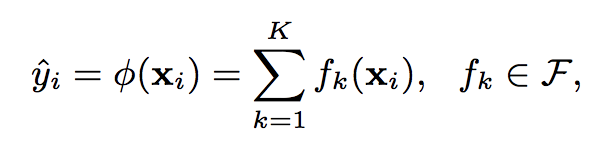

In [7]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

In [9]:
def run_model(tr_x,tr_y,tst_x,tst_y):
    LR = LinearRegression()
    LR.fit(tr_x,tr_y)
    MAEL = mean_absolute_error(LR.predict(tst_x),tst_y)
    
    XGB = xgb.XGBRegressor(n_estimators = 50)
    XGB.fit(tr_x,tr_y)
    MAEGB = mean_absolute_error(XGB.predict(tst_x),tst_y)
    
    return MAEL,MAEGB

In [10]:
#only PM2.5
#training(10-11)
x1,y1 = forecast_PM(train_d,1)
x6,y6 = forecast_PM(train_d,6)

#testing data (12)
x1t,y1t = forecast_PM(train_d,1)
x6t,y6t = forecast_PM(train_d,6)

print('Only PM2.5')
print('\n')
MAE_L1,MAE_XGB1 = run_model(x1,y1,x1t,y1t)
MAE_L6,MAE_XGB6 = run_model(x6,y6,x6t,y6t)

print('**PM2.5 MAE: 1hr prediction**')
#print('-------------------------')
print('MAE of Linear Regression:')
print(MAE_L1)
#print('\n')
print('MAE of XG-Boost:')
print(MAE_XGB1)
#print('\n')
print('-------------------------')
print('**PM2.5 MAE: 6hr prediction**')
print('MAE of Linear Regression:')
print(MAE_L6)
#print('\n')
print('MAE of XG-Boost:')
print(MAE_XGB6)

Only PM2.5


**PM2.5 MAE: 1hr prediction**
MAE of Linear Regression:
2.5890115545631684
MAE of XG-Boost:
1.19660947395205
-------------------------
**PM2.5 MAE: 6hr prediction**
MAE of Linear Regression:
3.8931600472455274
MAE of XG-Boost:
1.786152461439843


In [11]:
#all attributes
#training(10-11)
x1,y1 = forecast_all(train_d,1)
x6,y6 = forecast_all(train_d,6)
#transfer to dataframe

#testing data (12)
x1t,y1t = forecast_all(train_d,1)
x6t,y6t = forecast_all(train_d,6)

print('All attributes')

MAE_L1,MAE_XGB1 = run_model(x1,y1,x1t,y1t)
MAE_L6,MAE_XGB6 = run_model(x6,y6,x6t,y6t)

print('Only PM2.5')
print('\n')
MAE_L1,MAE_XGB1 = run_model(x1,y1,x1t,y1t)
MAE_L6,MAE_XGB6 = run_model(x6,y6,x6t,y6t)

print('**All attributes MAE: 1hr prediction**')
#print('-------------------------')
print('MAE of Linear Regression:')
print(MAE_L1)
#print('\n')
print('MAE of XG-Boost:')
print(MAE_XGB1)
#print('\n')
print('-------------------------')
print('**All attributes MAE: 6hr prediction**')
print('MAE of Linear Regression:')
print(MAE_L6)
#print('\n')
print('MAE of XG-Boost:')
print(MAE_XGB6)

All attributes
Only PM2.5


**All attributes MAE: 1hr prediction**
MAE of Linear Regression:
2.393532105241653
MAE of XG-Boost:
0.28081295743651064
-------------------------
**All attributes MAE: 6hr prediction**
MAE of Linear Regression:
3.6319869812973633
MAE of XG-Boost:
0.4235681037162799
